# Tweets Analysis

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
from time import time
import warnings
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, fbeta_score, accuracy_score, confusion_matrix, plot_roc_curve, ConfusionMatrixDisplay, make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from imblearn.over_sampling import RandomOverSampler


## 2. Read the Data

In [2]:
tweets = pd.read_csv('Tweets\\final_tweets_classified.csv')
tweets = tweets.drop(['Column1', 'index'], axis=1)
tweets = tweets.reset_index(drop=True)
tweets.head()


,ID,Tweet,Timestamp,Likes,Retweets,Length,Date,Time,Class
0,1.497300e+18,قبيل الاحتفال بـ اليوم الدولي لمراة تستعد كوكب...,2/25/22 23:00,1,0,198,2/25/2022,8:00:01 PM,positive
1,1.497300e+18,لحظات نزول دابانغ سلمان خان علا ارض المسرح اك...,2/25/22 22:57,2,0,207,2/25/2022,7:57:14 PM,positive
2,1.497300e+18,ليلة ميزة بانتظارنا الحانها شرقية نجومها است...,2/25/22 22:47,0,0,232,2/25/2022,7:47:38 PM,positive
3,1.497300e+18,اصدق حفلة احلا فستان مستان انا بختار واذا حفل...,2/25/22 22:40,3,1,168,2/25/2022,7:40:37 PM,positive
4,1.497290e+18,جنون بعده جنون دابانغ سلمان خان يستعرض حشد كب...,2/25/22 22:21,5,2,178,2/25/2022,7:21:09 PM,positive


In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         5875 non-null   float64
 1   Tweet      5875 non-null   object 
 2   Timestamp  5875 non-null   object 
 3   Likes      5875 non-null   int64  
 4   Retweets   5875 non-null   int64  
 5   Length     5875 non-null   int64  
 6   Date       5875 non-null   object 
 7   Time       5875 non-null   object 
 8   Class      5875 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 413.2+ KB


In [4]:
tweets.columns

Index(['ID', 'Tweet', 'Timestamp', 'Likes', 'Retweets', 'Length', 'Date',
       'Time', 'Class'],
      dtype='object')

## 3. Predective Statistics

### Data Preprocessing & Feature Extraction

In [5]:
tweets.head()

,ID,Tweet,Timestamp,Likes,Retweets,Length,Date,Time,Class
0,1.497300e+18,قبيل الاحتفال بـ اليوم الدولي لمراة تستعد كوكب...,2/25/22 23:00,1,0,198,2/25/2022,8:00:01 PM,positive
1,1.497300e+18,لحظات نزول دابانغ سلمان خان علا ارض المسرح اك...,2/25/22 22:57,2,0,207,2/25/2022,7:57:14 PM,positive
2,1.497300e+18,ليلة ميزة بانتظارنا الحانها شرقية نجومها است...,2/25/22 22:47,0,0,232,2/25/2022,7:47:38 PM,positive
3,1.497300e+18,اصدق حفلة احلا فستان مستان انا بختار واذا حفل...,2/25/22 22:40,3,1,168,2/25/2022,7:40:37 PM,positive
4,1.497290e+18,جنون بعده جنون دابانغ سلمان خان يستعرض حشد كب...,2/25/22 22:21,5,2,178,2/25/2022,7:21:09 PM,positive


In [6]:
# Drop the neutral class 
tweets = tweets[tweets.Class != 'neutral']
tweets = tweets.reset_index(drop=True)

In [7]:
# Convert the classes negative and positive to 0 and 1 respectively
tweets['Class'] = tweets['Class'].map({'negative': 0, 'positive': 1})

In [8]:
display(tweets.tail(10))

,ID,Tweet,Timestamp,Likes,Retweets,Length,Date,Time,Class
3401,1.510730e+18,الي مدبوغ مسوي انسحب و الي مشترك دورة تجارية م...,4/4/22 0:33,15,1,287,4/3/2022,9:33:33 PM,0
3402,1.510720e+18,حمد ماجد عبداله معرض اكسبو دبي حدثا فريدا ميزا,4/3/22 23:58,0,0,88,4/3/2022,8:58:37 PM,1
3403,1.510720e+18,اكبر حدث عالمي اكسبو دبي حق العالم,4/3/22 23:26,0,0,101,4/3/2022,8:26:59 PM,1
3404,1.510710e+18,جمال اكسبو وجمال دبي,4/3/22 23:07,0,0,38,4/3/2022,8:07:49 PM,1
3405,1.510710e+18,مشكورين بارك اله فيكم نتمنا نرا اكسبو الملكة...,4/3/22 23:06,8,0,187,4/3/2022,8:06:03 PM,1
3406,1.510710e+18,وداعا اكسبو دبي دولة زاءر راكب طرق دبي ...,4/3/22 23:04,0,0,273,4/3/2022,8:04:27 PM,1
3407,1.510700e+18,فعلا دبي استثناءية المعرض الهندي جوهم اكسبو,4/3/22 22:23,0,0,91,4/3/2022,7:23:32 PM,1
3408,1.510690e+18,اختام معرض اكسبو دبي يومين الخميس فرصة المعرض...,4/3/22 21:38,1,0,304,4/3/2022,6:38:24 PM,1
3409,1.510690e+18,الحمدله انجاز راءع شكرا الامارات الحبيبه نبارك...,4/3/22 21:30,0,2,160,4/3/2022,6:30:47 PM,1
3410,1.510690e+18,اكسبو ابرز الارقام القياسية حقها جناح السعودية...,4/3/22 21:30,0,0,100,4/3/2022,6:30:06 PM,1


In [9]:
X = tweets['Tweet']  # features
y = tweets['Class'] # classes

In [10]:
# Convert to a vector representation
unsampled_tfidf = TfidfVectorizer() 
unsampled_X = unsampled_tfidf.fit_transform(X)

In [11]:
unsampled_X

<3411x14747 sparse matrix of type '<class 'numpy.float64'>'
	with 53393 stored elements in Compressed Sparse Row format>

### Split the Data

In [12]:
X_train_unsampled, X_test_unsampled, y_train_unsampled, y_test_unsampled = train_test_split(unsampled_X, y, test_size=0.3, random_state=27)

In [13]:
print("Training set has {} samples.".format(X_train_unsampled.shape[0]))
print("Testing set has {} samples.".format(X_test_unsampled.shape[0]))

Training set has 2387 samples.
Testing set has 1024 samples.


In [14]:
upsampled_tfidf = TfidfVectorizer()
upsampled_tfidf.fit(X)

TfidfVectorizer()

In [15]:
X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(X, y, test_size=0.3, random_state=27)


In [16]:
print("Training set has {} samples.".format(X_train_upsampled.shape[0]))
print("Testing set has {} samples.".format(X_test_upsampled.shape[0]))

Training set has 2387 samples.
Testing set has 1024 samples.


In [17]:
X_train_upsampled = upsampled_tfidf.transform(X_train_upsampled)
X_test_upsampled = upsampled_tfidf.transform(X_test_upsampled)
upsampled_X = upsampled_tfidf.transform(X)


In [18]:
X_train_upsampled

<2387x14747 sparse matrix of type '<class 'numpy.float64'>'
	with 37175 stored elements in Compressed Sparse Row format>

In [19]:
ros = RandomOverSampler(random_state=27)

X_train_upsampled, y_train_upsampled = ros.fit_resample(X_train_upsampled, y_train_upsampled)

In [20]:
print("Data before upsampling: {} samples.".format(y_train_unsampled.value_counts()[0]))
print("Data before upsampling: {} samples.".format(y_train_unsampled.value_counts()[1]))

Data before upsampling: 148 samples.
Data before upsampling: 2239 samples.


In [21]:
print("Data after upsampling: {} samples.".format(y_train_upsampled.value_counts()[0]))
print("Data after upsampling: {} samples.".format(y_train_upsampled.value_counts()[1]))

Data after upsampling: 2239 samples.
Data after upsampling: 2239 samples.


### Training Pipeline
The goal is to create a function that trains, scores and predicts any model. This will allow for efficient model selection since we can supply the function with multiple models and compare the results to select the most appropriate one.

#### Function Inputs
> model: the classifier to be trained 
> X_train y_train X_test y_test, X and y
> 
   
#### Function Output
- result which is an array of the prediction time and scores respectively

In [22]:
def train_predict_pipeline(model, X_train, y_train, X_test, y_test, X, y):
    print("            {} Training            ".format(model.__class__.__name__))
    results = {}

    start = time()  # Training start
    model = model.fit(X_train, y_train) # Train the model
    end = time()  # Training end
    results['training_time'] = end - start # Store the time

    start = time()  # Prediction start
    predictions_test = model.predict(X_test) # Predict
    predictions_train = model.predict(X_train)
    end = time()  # Prediction end
    results['prediction_time'] = end - start # Store the time


    results['model_accuracy'] = model.score(X_train, y_train) # Overall accuracy

    # Cross validation score
    cross_validation_scores = cross_val_score(model,X, y, cv=10)
    results['model_cross_validation'] = np.mean(cross_validation_scores) 

    # Accuracy scores - for plotting
    results['accuracy_train'] = accuracy_score(y_train, predictions_train)
    results['accuracy_test'] = accuracy_score(y_test, predictions_test)

    # F-scores
    results['fbeta_train'] = fbeta_score(y_train, predictions_train, beta=0.5)
    results['fbeta_test'] = fbeta_score(y_test, predictions_test, beta=0.5)

    # Print the report
    print('            Accuracy Report            ')
    print('Model Accuracy: %.2f' % results['model_accuracy'])
    print('10-Fold Cross Validation: %.2f' % results['model_cross_validation'])
    print('F-beta Score (Training): %.2f' % results['fbeta_train'])
    print('F-beta Score (Testing): %.2f' % results['fbeta_test'])
    print('            Confusion Matrix            ')
    print(confusion_matrix(y_test, predictions_test))
    print(classification_report(y_test, predictions_test))

    display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['negative', 'positive'], cmap=plt.cm.Blues)
    display.ax_.set_title('Confusion Matrix Display')
    plt.show()

    # Return the results and the classifier
    return results, model


In [23]:
SVC_classifier = SVC(random_state=0,probability=True)
AdaBoost_classifier = AdaBoostClassifier(random_state=0)
Naivebayes_classifier = MultinomialNB()

            SVC Training            
            Accuracy Report            
Model Accuracy: 0.99
10-Fold Cross Validation: 0.94
F-beta Score (Training): 0.99
F-beta Score (Testing): 0.94
            Confusion Matrix            
[[  0  74]
 [  0 950]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        74
           1       0.93      1.00      0.96       950

    accuracy                           0.93      1024
   macro avg       0.46      0.50      0.48      1024
weighted avg       0.86      0.93      0.89      1024



C:\Users\dalal\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dalal\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dalal\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


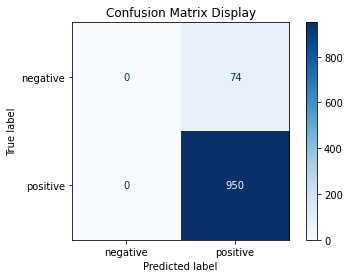

            AdaBoostClassifier Training            
            Accuracy Report            
Model Accuracy: 0.97
10-Fold Cross Validation: 0.94
F-beta Score (Training): 0.97
F-beta Score (Testing): 0.95
            Confusion Matrix            
[[ 16  58]
 [  9 941]]
              precision    recall  f1-score   support

           0       0.64      0.22      0.32        74
           1       0.94      0.99      0.97       950

    accuracy                           0.93      1024
   macro avg       0.79      0.60      0.64      1024
weighted avg       0.92      0.93      0.92      1024



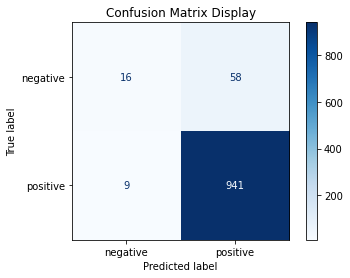

            MultinomialNB Training            
            Accuracy Report            
Model Accuracy: 0.94
10-Fold Cross Validation: 0.93
F-beta Score (Training): 0.95
F-beta Score (Testing): 0.94
            Confusion Matrix            
[[  0  74]
 [  0 950]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        74
           1       0.93      1.00      0.96       950

    accuracy                           0.93      1024
   macro avg       0.46      0.50      0.48      1024
weighted avg       0.86      0.93      0.89      1024



C:\Users\dalal\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dalal\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dalal\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


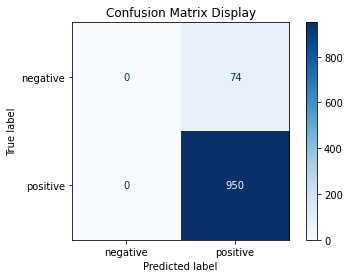

In [24]:
results_raw = {}

for classifier in [SVC_classifier, AdaBoost_classifier, Naivebayes_classifier]:
    classifier_name = classifier.__class__.__name__
    results_raw[classifier_name] = {}
    results_raw[classifier_name], classifier = train_predict_pipeline(
classifier, X_train_unsampled, y_train_unsampled, X_test_unsampled, y_test_unsampled, unsampled_X, y)

In [25]:
SVC_classifier = SVC(random_state=0, probability=True)
AdaBoost_classifier = AdaBoostClassifier(random_state=0)
Naivebayes_classifier = MultinomialNB()

            SVC Training            
            Accuracy Report            
Model Accuracy: 1.00
10-Fold Cross Validation: 0.94
F-beta Score (Training): 1.00
F-beta Score (Testing): 0.94
            Confusion Matrix            
[[  4  70]
 [  1 949]]
              precision    recall  f1-score   support

           0       0.80      0.05      0.10        74
           1       0.93      1.00      0.96       950

    accuracy                           0.93      1024
   macro avg       0.87      0.53      0.53      1024
weighted avg       0.92      0.93      0.90      1024



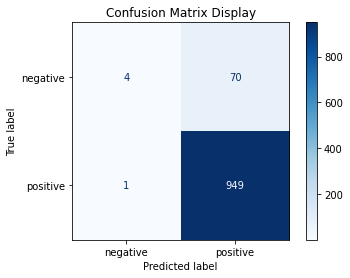

            AdaBoostClassifier Training            
            Accuracy Report            
Model Accuracy: 0.90
10-Fold Cross Validation: 0.94
F-beta Score (Training): 0.93
F-beta Score (Testing): 0.95
            Confusion Matrix            
[[ 53  21]
 [146 804]]
              precision    recall  f1-score   support

           0       0.27      0.72      0.39        74
           1       0.97      0.85      0.91       950

    accuracy                           0.84      1024
   macro avg       0.62      0.78      0.65      1024
weighted avg       0.92      0.84      0.87      1024



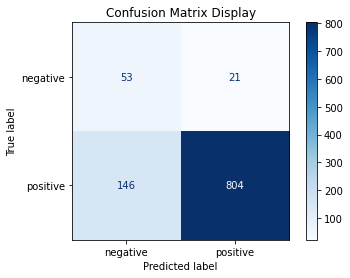

            MultinomialNB Training            
            Accuracy Report            
Model Accuracy: 0.99
10-Fold Cross Validation: 0.93
F-beta Score (Training): 1.00
F-beta Score (Testing): 0.97
            Confusion Matrix            
[[ 53  21]
 [ 61 889]]
              precision    recall  f1-score   support

           0       0.46      0.72      0.56        74
           1       0.98      0.94      0.96       950

    accuracy                           0.92      1024
   macro avg       0.72      0.83      0.76      1024
weighted avg       0.94      0.92      0.93      1024



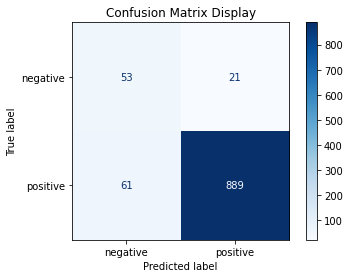

In [26]:
results = {}

for classifier in [SVC_classifier, AdaBoost_classifier, Naivebayes_classifier]:
    classifier_name = classifier.__class__.__name__
    results[classifier_name] = {}
    results[classifier_name], classifier = train_predict_pipeline(
        classifier, X_train_upsampled, y_train_upsampled, X_test_upsampled, y_test_upsampled, upsampled_X, y)


### Model Evaluation

In [27]:
results

{'SVC': {'training_time': 8.114627122879028,
  'prediction_time': 1.6106765270233154,
  'model_accuracy': 0.9997766860205449,
  'model_cross_validation': 0.9355035928041021,
  'accuracy_train': 0.9997766860205449,
  'accuracy_test': 0.9306640625,
  'fbeta_train': 0.9999106424805648,
  'fbeta_test': 0.944090728213291},
 'AdaBoostClassifier': {'training_time': 1.6581687927246094,
  'prediction_time': 0.05252575874328613,
  'model_accuracy': 0.9035283608753908,
  'model_cross_validation': 0.9355053077463943,
  'accuracy_train': 0.9035283608753908,
  'accuracy_test': 0.8369140625,
  'fbeta_train': 0.9335114277233599,
  'fbeta_test': 0.9458823529411764},
 'MultinomialNB': {'training_time': 0.010069847106933594,
  'prediction_time': 0.0,
  'model_accuracy': 0.9915140687807057,
  'model_cross_validation': 0.9349170825401725,
  'accuracy_train': 0.9915140687807057,
  'accuracy_test': 0.919921875,
  'fbeta_train': 0.9965589060943584,
  'fbeta_test': 0.9684095860566448}}

In [28]:
def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.

    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """

    # Create figure
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))

 # Constants
    bar_width = 0.3
    colors = ['#083471', '#1F6EB3', '#56A0CE']

    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['training_time', 'accuracy_train', 'fbeta_train', 'prediction_time', 'accuracy_test', 'fbeta_test']):
            ax[j//3, j % 3].bar(k*bar_width, results[learner]
                                [metric], width=bar_width, color=colors[k])

    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("Fbeta-score")

    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("Fbeta-score on Testing Set")

    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y=accuracy, xmin=-0.1, xmax=3.0,
                     linewidth=1, color='k', linestyle='dashed')
    ax[1, 1].axhline(y=accuracy, xmin=-0.1, xmax=3.0,
                     linewidth=1, color='k', linestyle='dashed')
    ax[0, 2].axhline(y=f1, xmin=-0.1, xmax=3.0, linewidth=1,
                     color='k', linestyle='dashed')
    ax[1, 2].axhline(y=f1, xmin=-0.1, xmax=3.0, linewidth=1,
                     color='k', linestyle='dashed')

    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color=colors[i], label=learner))
    plt.legend(handles=patches, bbox_to_anchor=(-.80, 2.53),
               loc='upper center', borderaxespad=0., ncol=3, fontsize='x-large')

    # Aesthetics
    plt.suptitle(
        "Performance Metrics for Three Supervised Learning Models", fontsize=16, y=1.10)
    plt.show()


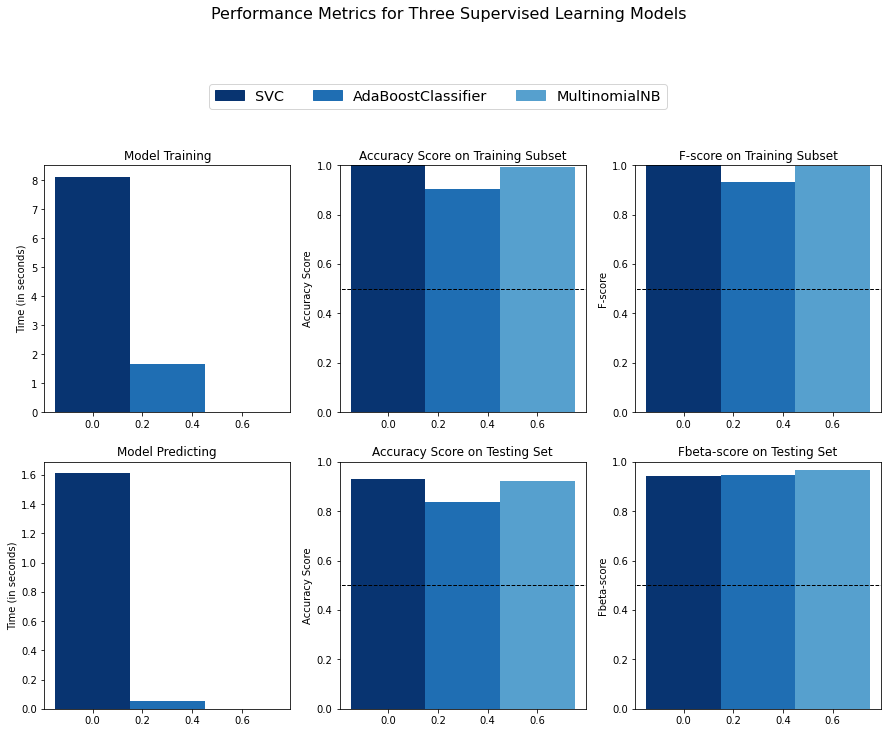

In [29]:
evaluate(results, 0.5, 0.5)


C:\Users\dalal\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dalal\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dalal\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`

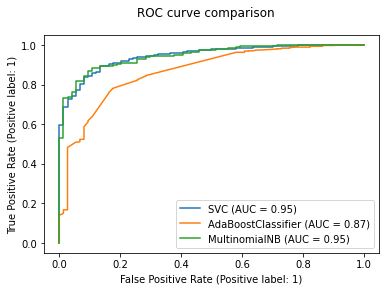

In [30]:
svc_display = plot_roc_curve(SVC_classifier, X_test_upsampled, y_test_upsampled)
ada_display = plot_roc_curve(AdaBoost_classifier, X_test_upsampled, y_test_upsampled, ax=svc_display.ax_)
naive_display = plot_roc_curve(Naivebayes_classifier, X_test_upsampled, y_test_upsampled, ax=ada_display.ax_)
naive_display.figure_.suptitle("ROC curve comparison")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

plt.show()


### Fine Tuning

In [31]:
parameters = {'C': [0.1, 1, 1.1, 2, 10, 100],
              'kernel': ['linear']}

In [32]:
scorer = make_scorer(fbeta_score, beta=0.5)
grid = GridSearchCV(SVC(random_state=0), param_grid=parameters, scoring=scorer, refit=True, cv=10, verbose=3)

In [33]:
gridSVC = grid.fit(X_train_upsampled, y_train_upsampled)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV 1/10] END .............C=0.1, kernel=linear;, score=0.990 total time=   1.6s
[CV 2/10] END .............C=0.1, kernel=linear;, score=0.999 total time=   1.6s
[CV 3/10] END .............C=0.1, kernel=linear;, score=0.996 total time=   1.7s
[CV 4/10] END .............C=0.1, kernel=linear;, score=0.998 total time=   1.6s
[CV 5/10] END .............C=0.1, kernel=linear;, score=0.986 total time=   1.6s
[CV 6/10] END .............C=0.1, kernel=linear;, score=0.992 total time=   1.7s
[CV 7/10] END .............C=0.1, kernel=linear;, score=0.993 total time=   1.7s
[CV 8/10] END .............C=0.1, kernel=linear;, score=0.995 total time=   1.6s
[CV 9/10] END .............C=0.1, kernel=linear;, score=0.989 total time=   1.6s
[CV 10/10] END ............C=0.1, kernel=linear;, score=0.979 total time=   1.5s
[CV 1/10] END ...............C=1, kernel=linear;, score=0.997 total time=   0.6s
[CV 2/10] END ...............C=1, kernel=linear;

In [34]:
gridSVC.best_estimator_

SVC(C=1, kernel='linear', random_state=0)

In [35]:
# Original SVC accuracy
results['SVC']['accuracy_test']

0.9306640625

In [36]:
# Original SVC fbeta score
results['SVC']['fbeta_test']

0.944090728213291

In [37]:
# Fine tuned SVC accuracy
accuracy_score(y_test_upsampled, gridSVC.predict(X_test_upsampled))

0.939453125

In [38]:
# Fine tuned SVC fbeta score
fbeta_score(y_test_upsampled, gridSVC.predict(X_test_upsampled), beta=0.5)

0.9519501407318053

            SVC Training            
            Accuracy Report            
Model Accuracy: 1.00
10-Fold Cross Validation: 0.94
F-beta Score (Training): 1.00
F-beta Score (Testing): 0.95
            Confusion Matrix            
[[ 15  59]
 [  3 947]]
              precision    recall  f1-score   support

           0       0.83      0.20      0.33        74
           1       0.94      1.00      0.97       950

    accuracy                           0.94      1024
   macro avg       0.89      0.60      0.65      1024
weighted avg       0.93      0.94      0.92      1024



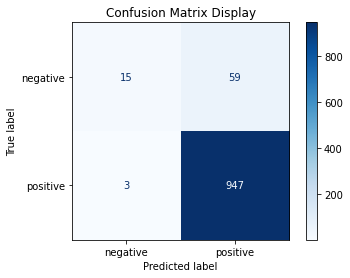

({'training_time': 0.6990411281585693,
  'prediction_time': 0.850391149520874,
  'model_accuracy': 0.9993300580616347,
  'model_cross_validation': 0.943413764126837,
  'accuracy_train': 0.9993300580616347,
  'accuracy_test': 0.939453125,
  'fbeta_train': 0.9997317356702137,
  'fbeta_test': 0.9519501407318053},
 SVC(C=1, kernel='linear', random_state=0))

In [39]:
train_predict_pipeline(SVC(C=1, kernel='linear', random_state=0), X_train_upsampled, y_train_upsampled, X_test_upsampled, y_test_upsampled, upsampled_X, y)
